In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# Imporing libiaries and data

In [2]:

# model building
import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import math

# pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

# feature selection
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns


# viewing train and test data 

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [6]:
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [7]:
pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test']).T
# Viewing number of NaN values

,train,test
id,0.0,0.0
person_age,0.0,0.0
person_income,0.0,0.0
person_home_ownership,0.0,0.0
person_emp_length,0.0,0.0
loan_intent,0.0,0.0
loan_grade,0.0,0.0
loan_amnt,0.0,0.0
loan_int_rate,0.0,0.0
loan_percent_income,0.0,0.0


In [8]:
train.nunique()
#Looking for Outliers


id                            58645
person_age                       53
person_income                  2641
person_home_ownership             4
person_emp_length                36
loan_intent                       6
loan_grade                        7
loan_amnt                       545
loan_int_rate                   362
loan_percent_income              61
cb_person_default_on_file         2
cb_person_cred_hist_length       29
loan_status                       2
dtype: int64

In [9]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_length',\
                  'loan_amnt', 'loan_int_rate', 'loan_percent_income',\
                  'cb_person_cred_hist_length']
#encoding in person

In [10]:
for c in categorical_cols:
    print(train[c].value_counts())
    print('__________________________')

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64
__________________________
loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64
__________________________
loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64
__________________________
cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64
__________________________


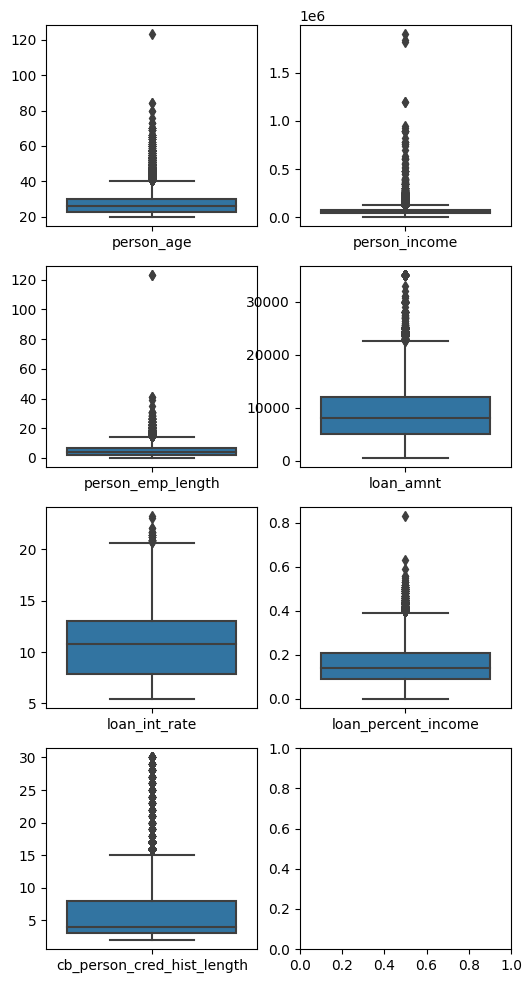

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(3*2,3*4))
def box(i):
    plot = sns.boxplot(train[numerical_cols].iloc[:, [i]], ax=axes[i//2][i%2])
for i in range(7):
        box(i)
plt.show()# Box line charts to assess data stabilization

# data cleaning

In [12]:
num_or_float_columns = train.select_dtypes(['int', 'float']).columns
columns = num_or_float_columns[1:-1]  
outlier_dict = {}
new_train = train.copy()

def IQR(column):
    q1 = np.percentile(train[column], 25)
    q3 = np.percentile(train[column], 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    higher_fence = q3 + 1.5 * iqr
    global new_train
    outliers = new_train[(new_train[column] < lower_fence) | (new_train[column] > higher_fence)]
    new_train = new_train[~((new_train[column] < lower_fence) | (new_train[column] > higher_fence))]
    outlier_dict[column] = outliers
    print(f"Outliers detected for {column}: {len(outliers)}")

for i in columns:
    IQR(i)

print("Before Dropping null values:", train.shape)
print("After Dropping null values:", new_train.shape)


Outliers detected for person_age: 2446
Outliers detected for person_income: 2242
Outliers detected for person_emp_length: 944
Outliers detected for loan_amnt: 1403
Outliers detected for loan_int_rate: 28
Outliers detected for loan_percent_income: 928
Outliers detected for cb_person_cred_hist_length: 772
Before Dropping null values: (58645, 13)
After Dropping null values: (49882, 13)


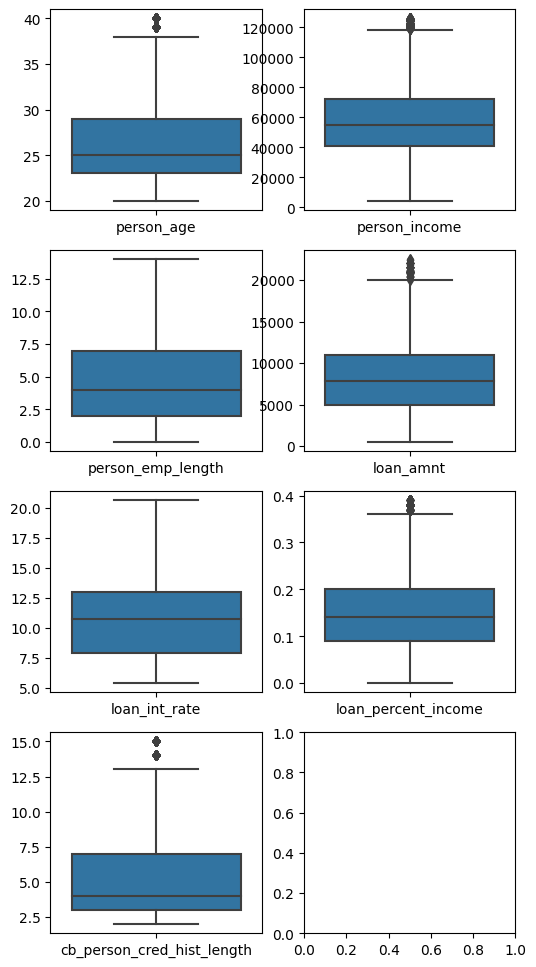

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(3*2,3*4))
def box(i):
    plot = sns.boxplot(new_train[numerical_cols].iloc[:, [i]], ax=axes[i//2][i%2])
for i in range(7):
        box(i)
plt.show()

In [14]:
new_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,49882.000000,49882.000000,49882.000000,49882.000000,49882.000000,49882.000000,49882.000000,49882.000000,49882.000000
mean,29258.815926,26.349485,58888.569263,4.392005,8386.891103,10.618996,0.153148,5.082976,0.128604
std,16921.191676,4.194200,23167.423848,3.373173,4500.792722,3.009507,0.081244,3.027005,0.334764
min,0.000000,20.000000,4200.000000,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14606.250000,23.000000,41000.000000,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29226.000000,25.000000,55000.000000,4.000000,7800.000000,10.740000,0.140000,4.000000,0.000000
75%,43894.750000,29.000000,72000.000000,7.000000,11000.000000,12.980000,0.200000,7.000000,0.000000
max,58644.000000,40.000000,126000.000000,14.000000,22500.000000,20.620000,0.390000,15.000000,1.000000


# plotting correlation and feature selecting

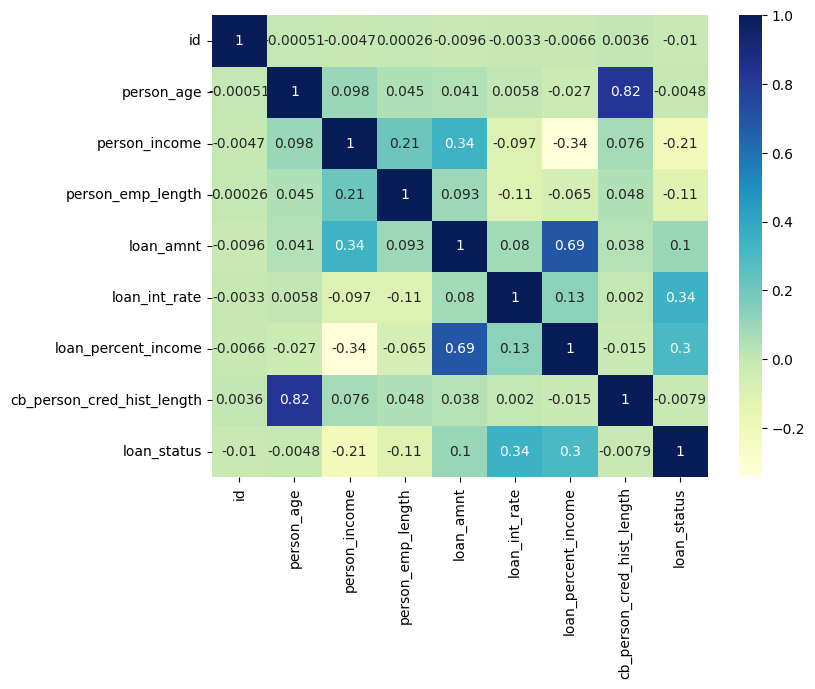

In [15]:
# Plotting correlation heatmap
fig, ax = plt.subplots(figsize=(8,6))
dataplot = sns.heatmap(new_train.corr(numeric_only=True), cmap="YlGnBu", annot=True, ax=ax)

# Displaying heatmap
plt.show()

In [16]:
# droping the target column and 'id' because it isn't a feature
X = new_train.drop(['loan_status', 'id'], axis=1)
y = new_train['loan_status']
X.head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)


In [18]:
print(pd.DataFrame(y_train).value_counts())


loan_status
0              30377
1               4540
Name: count, dtype: int64


In [19]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# define pipeline
over = SMOTENC(sampling_strategy = 0.4, categorical_features=[2, 4, 5, 9],\
               k_neighbors = 100, random_state = 42)
# transform the dataset
X_train, y_train = over.fit_resample(X_train, y_train)

print(pd.DataFrame(y_train).value_counts())

loan_status
0              30377
1              12150
Name: count, dtype: int64


In [20]:
X_train.columns


Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [21]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [22]:
test_transformed = test.copy()

# prepare output data by converting categories into numbers
oe = OrdinalEncoder()
oe.fit(X_train[categorical_cols])
X_train[categorical_cols] = oe.transform(X_train[categorical_cols])
X_test[categorical_cols] = oe.transform(X_test[categorical_cols])
test_transformed[categorical_cols] = oe.transform(test_transformed[categorical_cols])

Feature 0: 5755.158794
Feature 1: 670.551130
Feature 2: 12507.398018
Feature 3: 0.002174


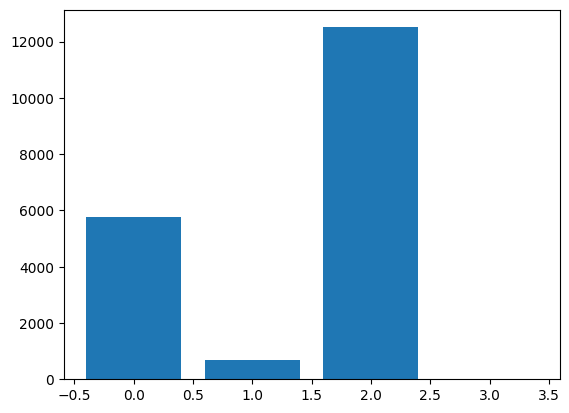

In [23]:
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs


# applying feature selection on the training data
X_train_fs, fs = select_features(X_train[categorical_cols], y_train)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We know from the chart that person_age, cb_person_cred_hist_length, cb_person_default_on_file have little relation to loan_status.

In [24]:
X_train = X_train.drop(['person_age', 'cb_person_cred_hist_length', 'cb_person_default_on_file'], axis=1)
X_test = X_test.drop(['person_age', 'cb_person_cred_hist_length', 'cb_person_default_on_file'], axis=1)
test_transformed = test_transformed.drop(['person_age', 'cb_person_cred_hist_length', 'cb_person_default_on_file'], axis=1)

# modeling and assessment 

In [26]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(max_depth=24, min_samples_leaf=1, min_samples_split=32, n_estimators=500, random_state=42)
# model.fit(X_train, y_train)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [ 200, 500,800],
    'max_depth': [ 20, 24,30],
    'min_samples_split': [10, 20, 32],
    'min_samples_leaf': [1, 2, 4],
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 800}
Best cross-validation score:  0.9710469777516195


In [26]:

model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=800,
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=800,
                       random_state=42)

In [27]:
y_pred = model.predict_proba(X_test)[:, 1]

y_pred

array([0.01334205, 0.84798737, 0.04922103, ..., 0.061522  , 0.01629933,
       0.00418625])

model 1 AUC score: 0.9297


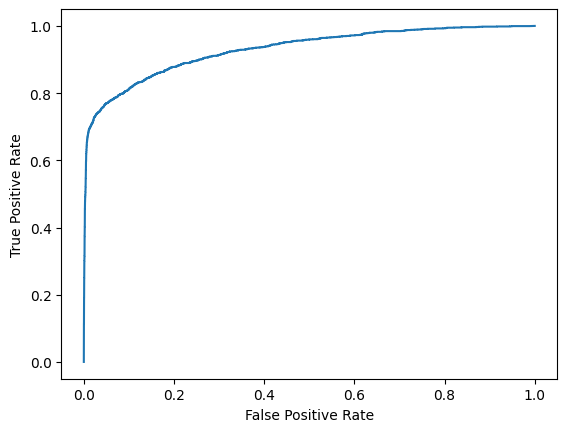

In [28]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC Area Under Curve (AUC)
print(f'model 1 AUC score: {roc_auc_score(y_test, y_pred):.4f}')

In [29]:
threshold = 0.5
y_pred = np.array((y_pred > threshold)) # 0.0 or 1.0

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)*100:.3f} %")

Accuracy Score: 95.122 %


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)
wrong_preds = X_test[np.logical_xor(y_test, y_pred)]
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for c in categorical_cols:
    print(wrong_preds[c].value_counts() / X_test[c].value_counts() *100)
    print('__________________________')

person_home_ownership
RENT        6.052015
MORTGAGE    3.692053
OWN         1.772152
OTHER       9.090909
Name: count, dtype: float64
__________________________
loan_intent
DEBTCONSOLIDATION    4.314396
EDUCATION            4.656183
HOMEIMPROVEMENT      9.233792
MEDICAL              4.854713
PERSONAL             5.677729
VENTURE              2.291584
Name: count, dtype: float64
__________________________
loan_grade
A     2.055293
B     4.379703
C     7.307415
D    11.924342
E    15.444015
F     6.896552
G          NaN
Name: count, dtype: float64
__________________________
cb_person_default_on_file
N    4.110020
Y    9.241071
Name: count, dtype: float64
__________________________


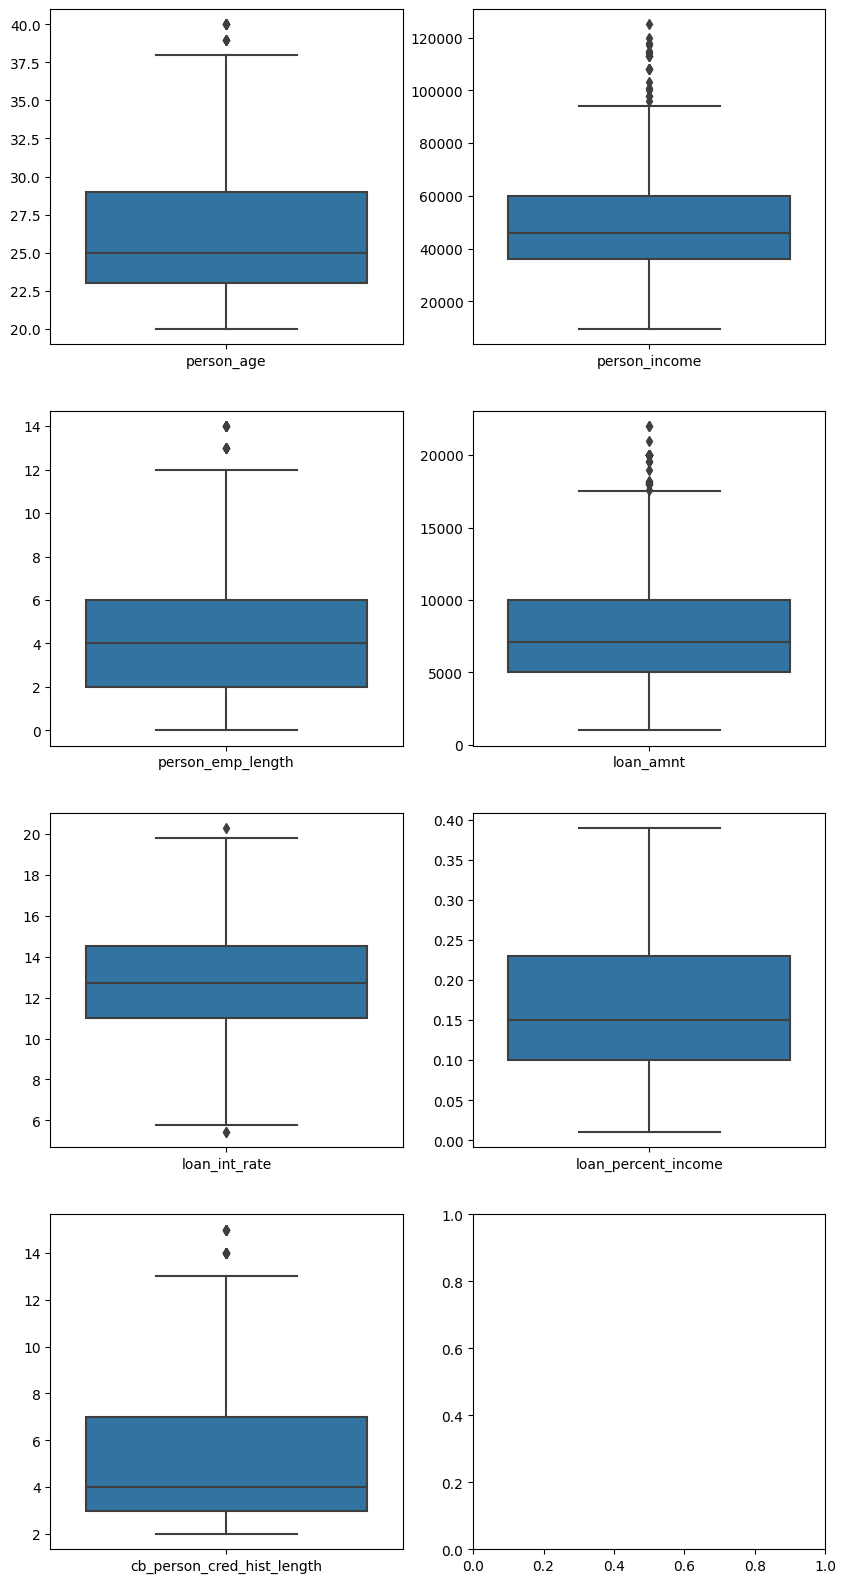

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(5*2,5*4))
def box(i):
    plot = sns.boxplot(wrong_preds[numerical_cols].iloc[:, [i]], ax=axes[i//2][i%2])
for i in range(7):
        box(i)
plt.show()

One analyzes the false predictions of categorical data , the other analyzes the distribution of numerical features.

# saving

In [32]:
# preparing the test data and converting it into a tensor
X_real = test_transformed.drop(['id'], axis=1)

# predicting the output of test data
y_real = model.predict_proba(X_real)[:, 1]
y_real
# getting the prepared submission file to edit on it
submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

# replacing the results with the new one
submission['loan_status'] = y_real

submission.head(2)
submission.to_csv('/kaggle/working/submission_1.csv',index=False)

# Other models building and assessment.

In [34]:
#LG boost model
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#  LGBMClassifier 
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
#transforming data type back to category
model = lgb.LGBMClassifier(max_depth=24, min_child_samples=1, min_split_gain=0.0, n_estimators=500, random_state=42)

model.fit(X_train, y_train)









[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4540, number of negative: 30377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 34917, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130023 -> initscore=-1.900759
[LightGBM] [Info] Start training from score -1.900759


LGBMClassifier(max_depth=24, min_child_samples=1, n_estimators=500,
               random_state=42)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Text(0, 0.5, 'True Positive Rate')

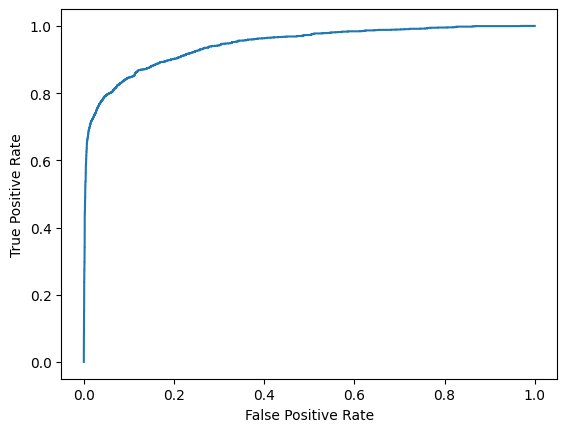

In [39]:
y_pred_lgb = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [40]:
print(f'model 1 AUC score: {roc_auc_score(y_test, y_pred_lgb):.4f}')


threshold = 0.5
y_pred_binary = (y_pred_lgb > threshold).astype(int)


print(f"Accuracy Score: {accuracy_score(y_test, y_pred_binary) * 100:.3f} %")



model 1 AUC score: 0.9447
Accuracy Score: 95.062 %


In [41]:
wrong_preds_lgb = X_test[np.logical_xor(y_test, y_pred_binary)]

for c in categorical_cols:
    print(wrong_preds_lgb[c].value_counts() / X_test[c].value_counts() * 100)
    print('__________________________')


person_home_ownership
RENT        5.941082
MORTGAGE    4.039735
OWN         1.645570
OTHER       0.000000
Name: count, dtype: float64
__________________________
loan_intent
DEBTCONSOLIDATION    4.997864
EDUCATION            4.378662
HOMEIMPROVEMENT      6.876228
MEDICAL              5.173636
PERSONAL             6.357457
VENTURE              2.765705
Name: count, dtype: float64
__________________________
loan_grade
A     2.491815
B     4.553347
C     7.307415
D    10.855263
E    10.810811
F    10.344828
G     0.000000
Name: count, dtype: float64
__________________________
cb_person_default_on_file
N    4.267191
Y    8.750000
Name: count, dtype: float64
__________________________


In [45]:
print(X_train['person_home_ownership'].value_counts())
print(X_test['person_home_ownership'].value_counts())
print(X_train['loan_grade'].value_counts())
print(X_test['loan_grade'].value_counts())

person_home_ownership
RENT        18765
MORTGAGE    14213
OWN          1885
OTHER          54
Name: count, dtype: int64
person_home_ownership
RENT        8113
MORTGAGE    6040
OWN          790
OTHER         22
Name: count, dtype: int64
loan_grade
A    12737
B    11993
C     6760
D     2822
E      539
F       56
G       10
Name: count, dtype: int64
loan_grade
A    5498
B    5183
C    2778
D    1216
E     259
F      29
G       2
Name: count, dtype: int64


For results with an error rate of 0, the reason given was that the sample size after screening was too small

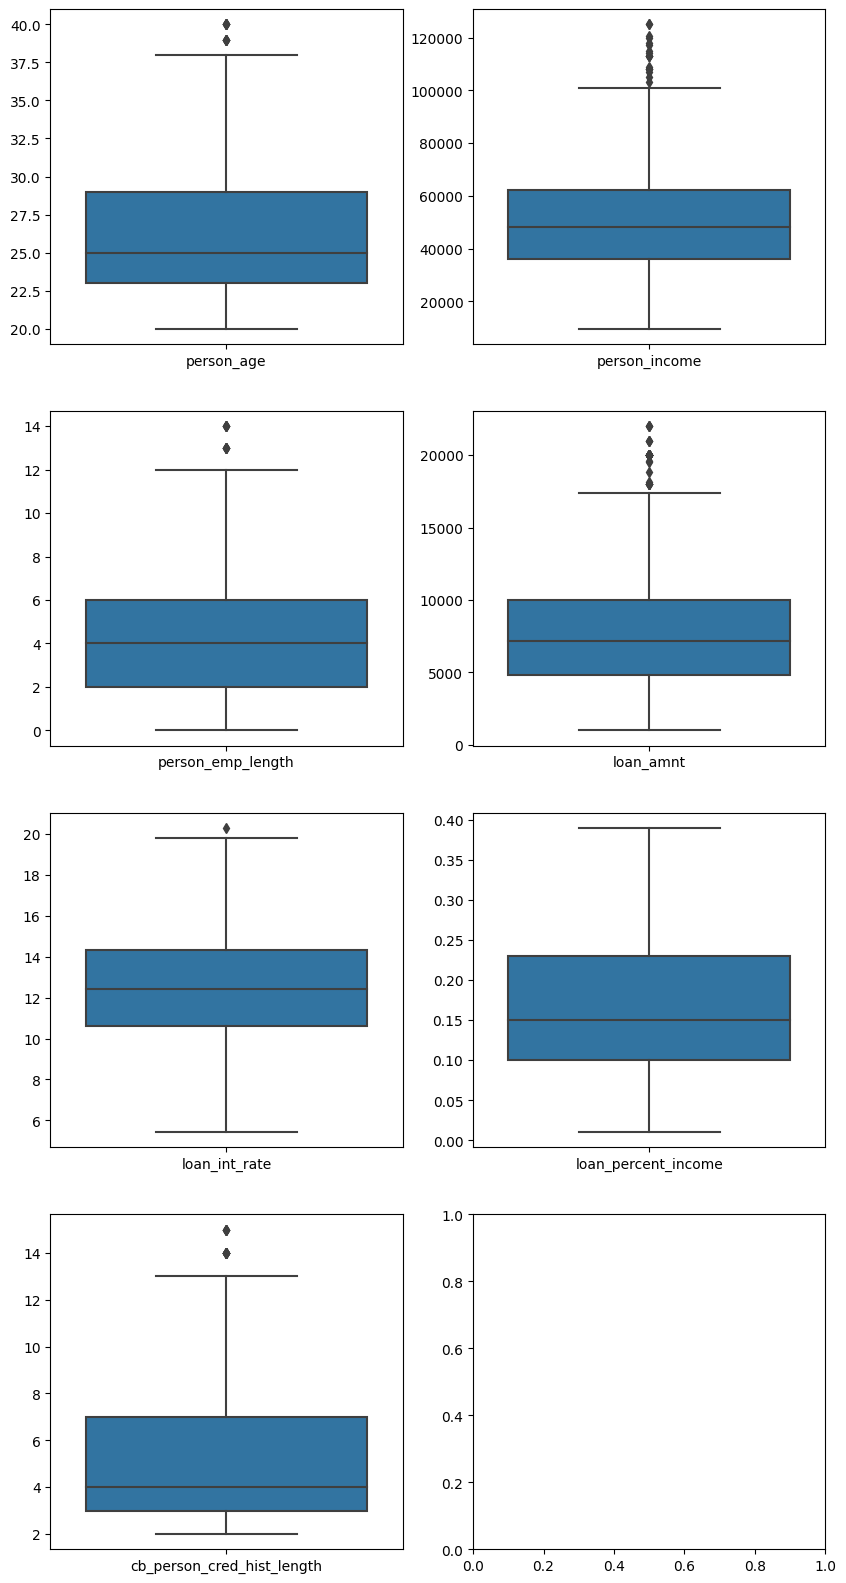

In [42]:
fig, axes = plt.subplots(4, 2, figsize=(5 * 2, 5 * 4))

def box(i):
    plot = sns.boxplot(wrong_preds_lgb[numerical_cols].iloc[:, [i]], ax=axes[i // 2][i % 2])

for i in range(7):
    box(i)

plt.show()

Text(0, 0.5, 'True Positive Rate')

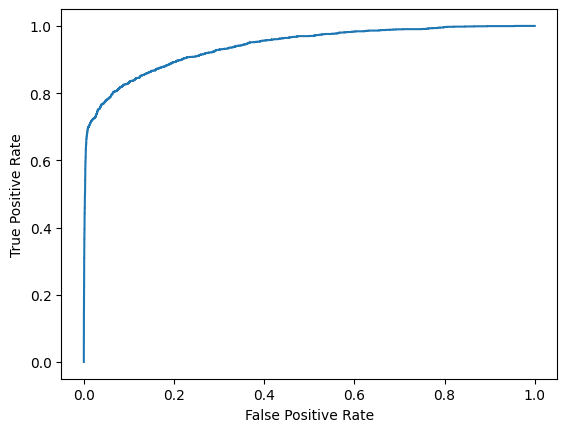

In [48]:
#xgb
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
# for col in categorical_cols:
#     X_train[col] = X_train[col].astype('category')
#     X_test[col] = X_test[col].astype('category')

model = xgb.XGBClassifier(max_depth=24, min_child_weight=1, learning_rate=0.1, n_estimators=500, random_state=42, enable_categorical=True)
#cuz xgb model do not support the categorical type, using 'enable_categorical=True' to make sure it can go on.
model.fit(X_train, y_train)

y_pred_xgb = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')








In [49]:

print(f'model 2 AUC score: {roc_auc_score(y_test, y_pred_xgb):.4f}')

threshold = 0.5
y_pred_binary = (y_pred_xgb > threshold).astype(int)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred_binary) * 100:.3f} %")

model 2 AUC score: 0.9394
Accuracy Score: 95.209 %


In [50]:

wrong_preds_xgb = X_test[np.logical_xor(y_test, y_pred_binary)]

# 打印每个类别的错误预测比例
for c in categorical_cols:
    print(wrong_preds_xgb[c].value_counts() / X_test[c].value_counts() * 100)
    print('__________________________')


person_home_ownership
RENT        5.904105
MORTGAGE    3.692053
OWN         1.772152
OTHER       4.545455
Name: count, dtype: float64
__________________________
loan_intent
DEBTCONSOLIDATION    5.083298
EDUCATION            4.286155
HOMEIMPROVEMENT      6.876228
MEDICAL              5.102764
PERSONAL             5.917633
VENTURE              2.449625
Name: count, dtype: float64
__________________________
loan_grade
A     2.182612
B     4.495466
C     7.487401
D    10.032895
E    12.355212
F     6.896552
G     0.000000
Name: count, dtype: float64
__________________________
cb_person_default_on_file
N    4.086444
Y    8.794643
Name: count, dtype: float64
__________________________


In [52]:

print(X_train['loan_grade'].value_counts())
print(X_test['loan_grade'].value_counts())

loan_grade
A    12737
B    11993
C     6760
D     2822
E      539
F       56
G       10
Name: count, dtype: int64
loan_grade
A    5498
B    5183
C    2778
D    1216
E     259
F      29
G       2
Name: count, dtype: int64


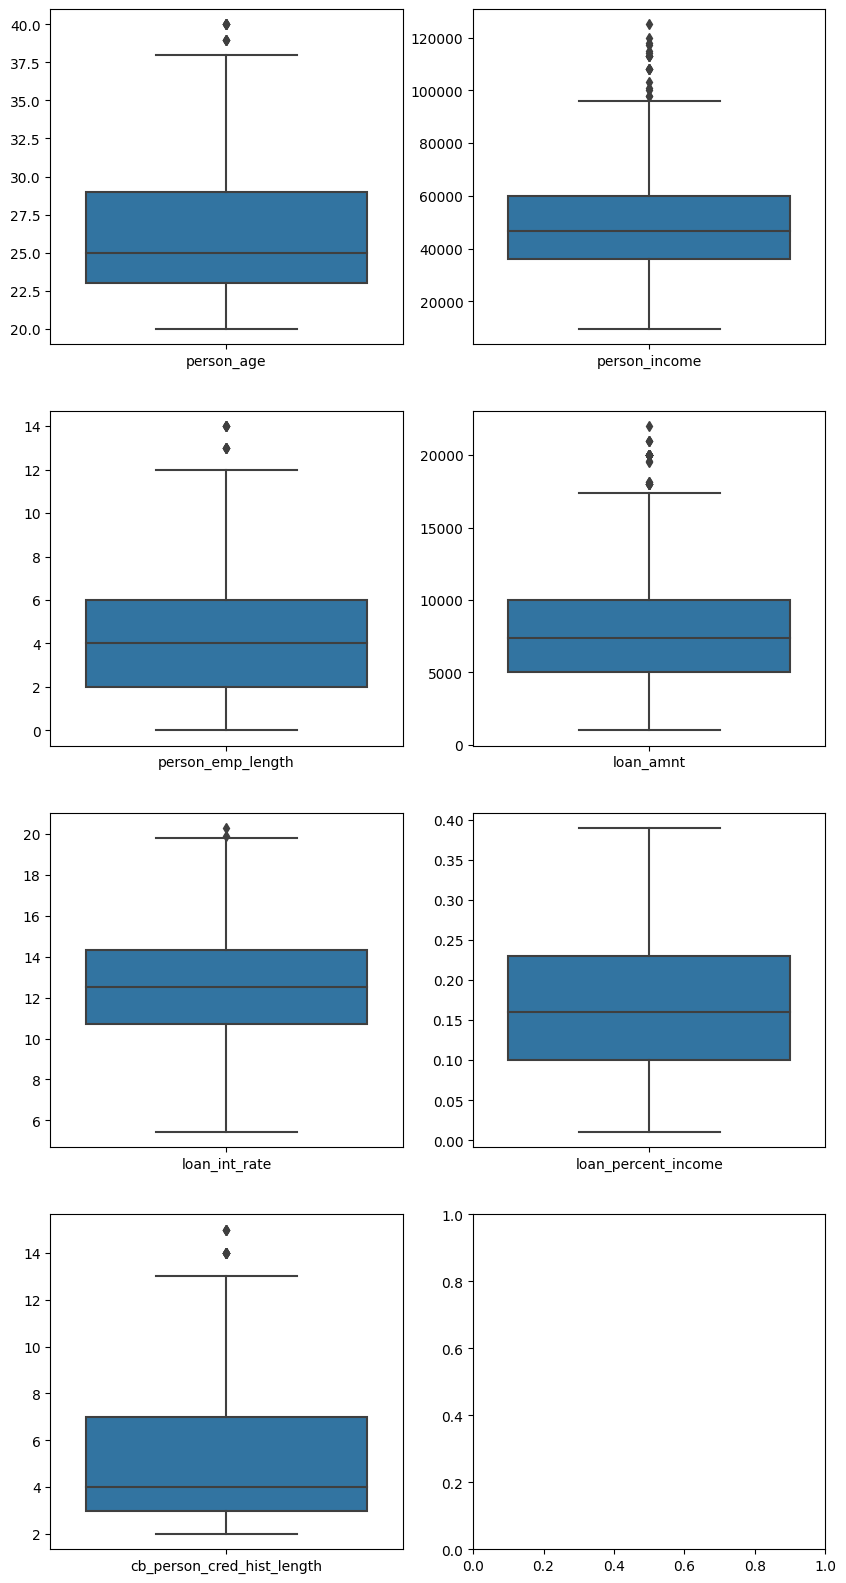

In [51]:

fig, axes = plt.subplots(4, 2, figsize=(5 * 2, 5 * 4))

def box(i):
    plot = sns.boxplot(wrong_preds_xgb[numerical_cols].iloc[:, [i]], ax=axes[i // 2][i % 2])

for i in range(7):
    box(i)

plt.show()

# Through comparison, we can get a conclusion.


AUC SCORE:

    random forest model:95.122 %
    
    lgb model：95.062 %

    xgb model: 95.209 %

Seems like they've got little difference.

categorical_cols:

    Random forest model has the highest error rate

numerical_cols:

    they all perform bad in preson_income